EDA SmartApply

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load dataset
df = pd.read_csv("C:/Users/poona/Desktop/MS_ADS/sem3/ML 2/SmartApply/data/postings.csv")

print("Dataset Shape:", df.shape)
print("\nSample rows:\n", df.head())
print("\nColumn info:\n")
df.info()


Dataset Shape: (123847, 31)

Sample rows:
      job_id            company_name  \
0    921716   Corcoran Sawyer Smith   
1   1829192                     NaN   
2  10998357  The National Exemplar    
3  23221523  Abrams Fensterman, LLP   
4  35982263                     NaN   

                                               title  \
0                              Marketing Coordinator   
1                  Mental Health Therapist/Counselor   
2                        Assitant Restaurant Manager   
3  Senior Elder Law / Trusts and Estates Associat...   
4                                 Service Technician   

                                         description  max_salary pay_period  \
0  Job descriptionA leading real estate firm in N...        20.0     HOURLY   
1  At Aspen Therapy and Wellness , we are committ...        50.0     HOURLY   
2  The National Exemplar is accepting application...     65000.0     YEARLY   
3  Senior Associate Attorney - Elder Law / Trusts...    175000.0     

In [20]:
# Handling Missing Values

def handle_missing_data(df, strategy="mean"):
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype == "object":
                df.fillna({col: df[col].mode()[0]}, inplace = True)
            else:
                if strategy == "mean":
                    df[col].fillna(df[col].mean(), inplace=True)
                elif strategy == "median":
                    df[col].fillna(df[col].median(), inplace=True)
    return df

df = handle_missing_data(df)


C:\Users\poona\AppData\Local\Temp\ipykernel_44016\428659581.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


In [21]:
# Data Type Corrections

date_cols = ["original_listed_time", "listed_time", "closed_time", "expiry"]
categorical_cols = ["company_name", "title", "formatted_work_type", 
                    "formatted_experience_level", "location", "currency"]
float_cols = ["min_salary", "max_salary", "normalized_salary"]

def correcting_datatypes(df, date_cols=None, categorical_cols=None, float_cols=None):
    if date_cols:
        for col in date_cols:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors="coerce")
    if categorical_cols:
        for col in categorical_cols:
            df[col] = df[col].astype("category")
    if float_cols:
        for col in float_cols:
            df[col] = df[col].astype(float)
    return df

df = correcting_datatypes(df, date_cols, categorical_cols, float_cols)


In [22]:
# Salary Normalization 

def normalize_salary(df):
    df = df.copy()
    df["pay_period"] = df["pay_period"].astype(str).str.lower().str.strip()

    conversion = {
        'hourly': 2080,
        'daily': 260,
        'weekly': 52,
        'biweekly': 26,
        'monthly': 12,
        'yearly': 1
    }

    df["avg_salary"] = df[["min_salary", "max_salary"]].mean(axis=1, skipna=True)
    df["normalized_salary"] = df.apply(
        lambda x: x["avg_salary"] * conversion.get(x["pay_period"], 1)
        if pd.notnull(x["avg_salary"]) else np.nan,
        axis=1
    )

    return df

df = normalize_salary(df)



In [23]:
# Remove extreme outliers (e.g., salaries above $500,000)
df = df[df["normalized_salary"] <= 500000]

# (Optional) Also remove negative or zero salaries if they exist
df = df[df["normalized_salary"] > 0]

print(f" Cleaned dataset shape: {df.shape}")


 Cleaned dataset shape: (119001, 32)


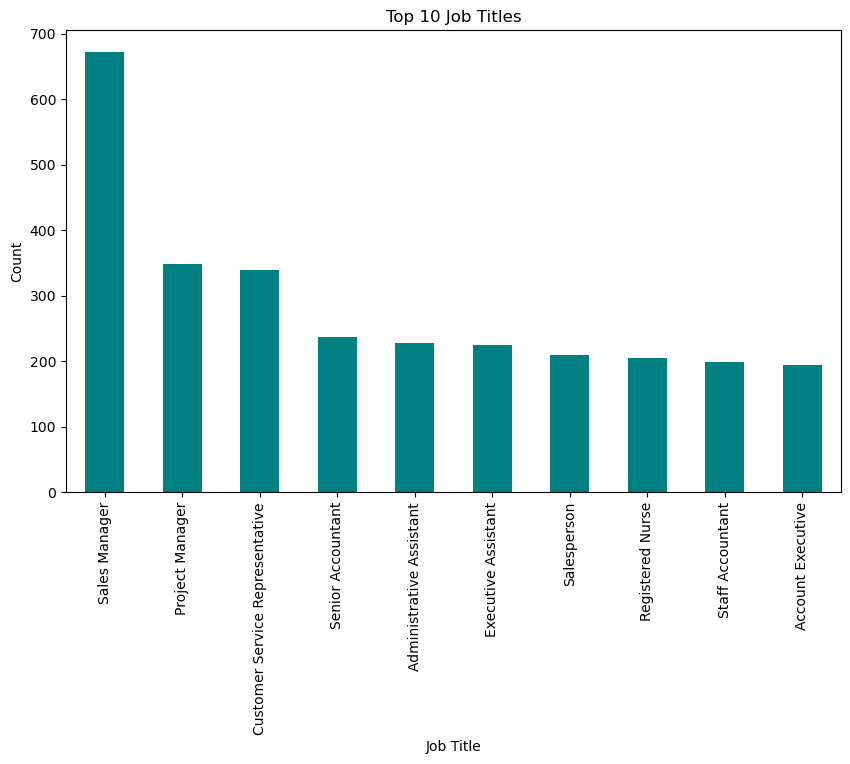

In [24]:


plt.figure(figsize=(10,6))
df["title"].value_counts().head(10).plot(kind="bar", color="teal")
plt.title("Top 10 Job Titles")
plt.xlabel("Job Title")
plt.ylabel("Count")
# Save the plot to a path
plt.savefig(r"C:/Users/poona/Desktop/MS_ADS/sem3/ML 2/SmartApply/results/top_10_job_title.png", dpi=300) 
plt.show()


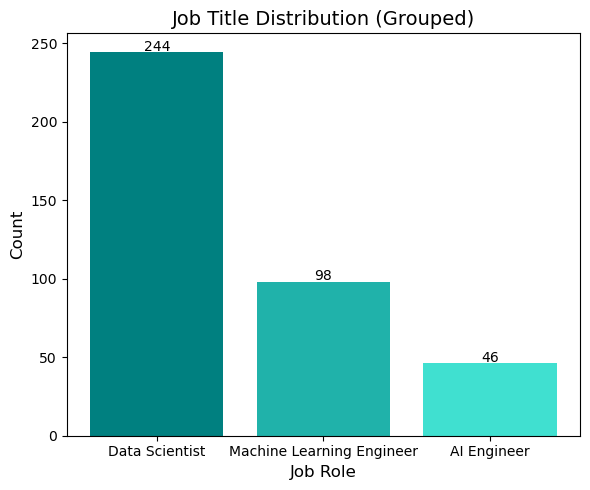

In [25]:

import warnings

# Suppress font warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Disable math text parsing
plt.rcParams['text.usetex'] = False

# Clean special characters from title column
df['title'] = df['title'].astype(str).str.replace('$', '', regex=False)

# Define groups of interest
groups = {
    "Data Scientist": ["data scientist"],
    "Machine Learning Engineer": ["machine learning engineer", "ml engineer"],
    "AI Engineer": ["ai engineer", "artificial intelligence engineer"]
}

# Create a new column to store general category
def categorize_title(title):
    title_lower = title.lower()
    for group, keywords in groups.items():
        if any(keyword in title_lower for keyword in keywords):
            return group
    return None  # ignore others

df["role_group"] = df["title"].apply(categorize_title)

# Filter only relevant roles
filtered_df = df[df["role_group"].notna()]

# Count grouped job roles
role_counts = filtered_df["role_group"].value_counts()

# Plot grouped bar chart
plt.figure(figsize=(6, 5))
bars = plt.bar(role_counts.index, role_counts.values, color=["#008080", "#20B2AA", "#40E0D0"])
plt.title("Job Title Distribution (Grouped)", fontsize=14)
plt.xlabel("Job Role", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Add value labels on top
for i, v in enumerate(role_counts.values):
    plt.text(i, v + 1, str(v), ha='center', fontsize=10)

plt.tight_layout()

# Save the plot to a path
plt.savefig(r"C:/Users/poona/Desktop/MS_ADS/sem3/ML 2/SmartApply/results/Job Distribution.png", dpi=300) 
plt.show()


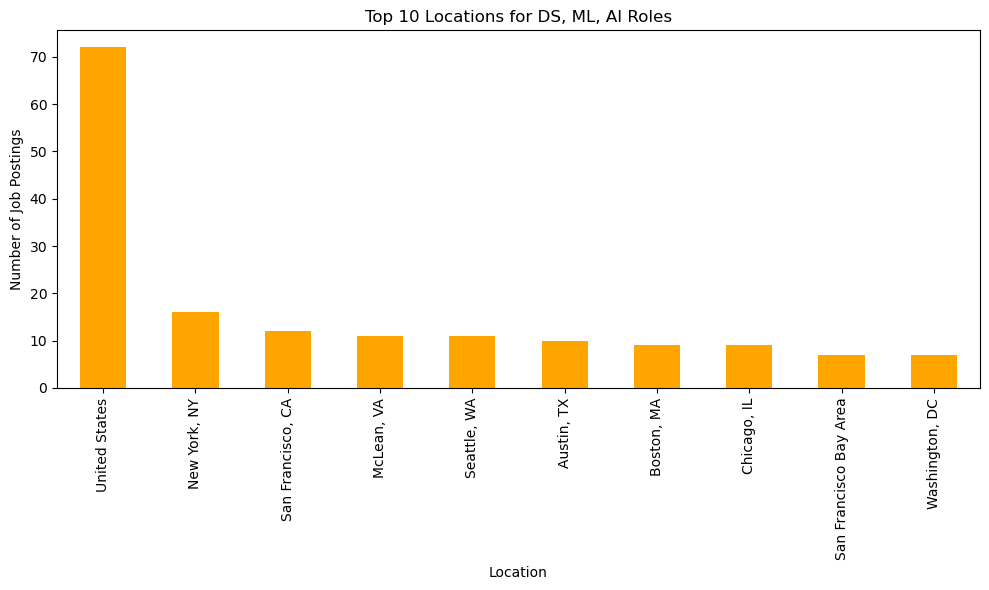

In [26]:
# Top 10 Locations (for selected roles)
plt.figure(figsize=(10,6))
filtered_df["location"].value_counts().head(10).plot(kind="bar", color="orange")
plt.title("Top 10 Locations for DS, ML, AI Roles")
plt.xlabel("Location")
plt.ylabel("Number of Job Postings")
plt.tight_layout()

# Save the plot to a path
plt.savefig(r"C:/Users/poona/Desktop/MS_ADS/sem3/ML 2/SmartApply/results/top_10_locations.png", dpi=300) 

plt.show()

C:\Users\poona\AppData\Local\Temp\ipykernel_44016\1605734740.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Role")


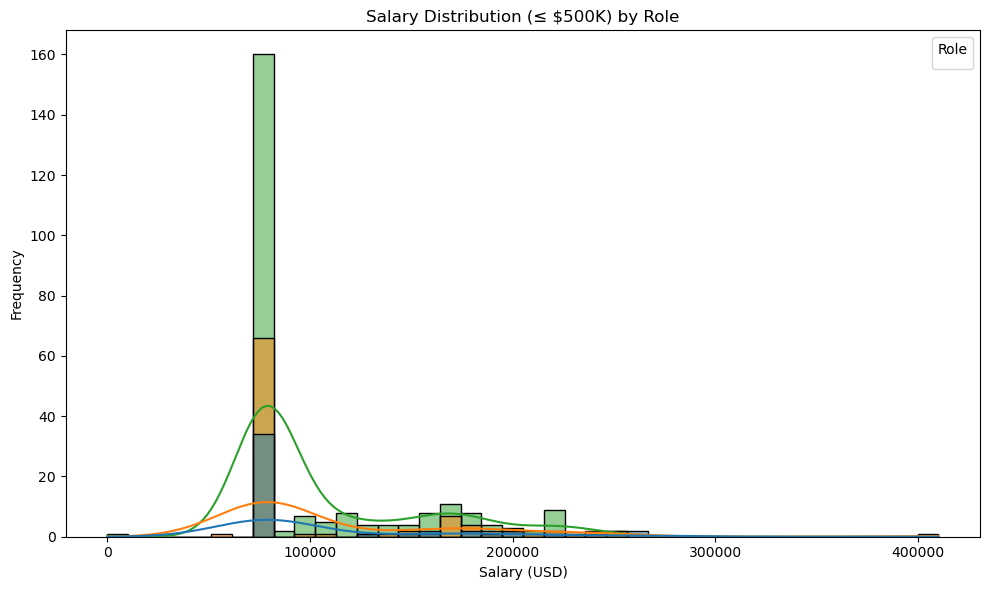

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Keep only relevant roles
filtered_df = df[df["role_group"].isin(["Data Scientist", "Machine Learning Engineer", "AI Engineer"])]

# Remove outliers — cap salaries at 500,000 USD
filtered_df = filtered_df[filtered_df["normalized_salary"] <= 500000]

# Salary Distribution by Role
plt.figure(figsize=(10,6))
sns.histplot(data=filtered_df, x="normalized_salary", hue="role_group", bins=40, kde=True)
plt.title("Salary Distribution (≤ $500K) by Role")
plt.xlabel("Salary (USD)")
plt.ylabel("Frequency")
plt.legend(title="Role")
plt.tight_layout()

# Save the plot to a path
plt.savefig(r"C:/Users/poona/Desktop/MS_ADS/sem3/ML 2/SmartApply/results/Salary_distribution.png", dpi=300) 
plt.show()


C:\Users\poona\AppData\Local\Temp\ipykernel_44016\3738154297.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="formatted_experience_level", y="normalized_salary", data=df, palette="viridis")


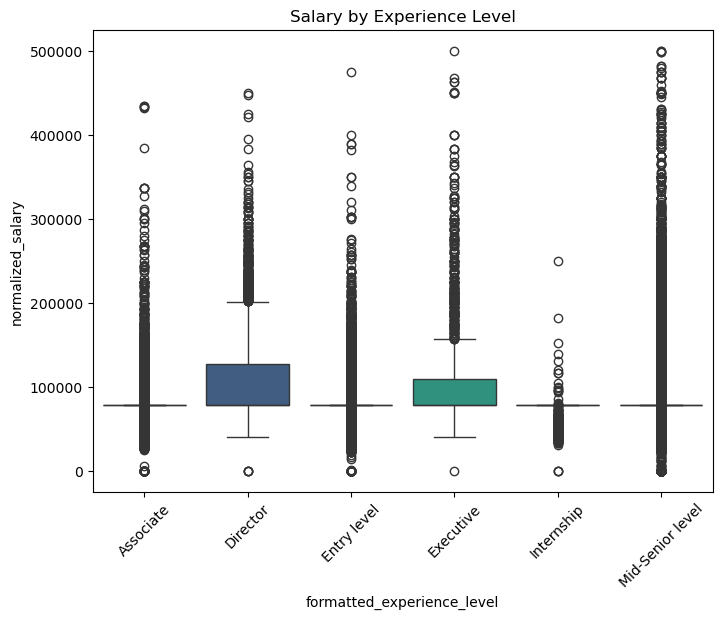

In [28]:
# Salary by Experience Level

plt.figure(figsize=(8,6))
sns.boxplot(x="formatted_experience_level", y="normalized_salary", data=df, palette="viridis")
plt.title("Salary by Experience Level")
plt.xticks(rotation=45)

# Save the plot to a path
plt.savefig(r"C:/Users/poona/Desktop/MS_ADS/sem3/ML 2/SmartApply/results/Salary_by_Experience_Level.png", dpi=300) 
plt.show()


C:\Users\poona\AppData\Local\Temp\ipykernel_44016\3159916399.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="formatted_work_type", y="normalized_salary", data=df, palette="mako")


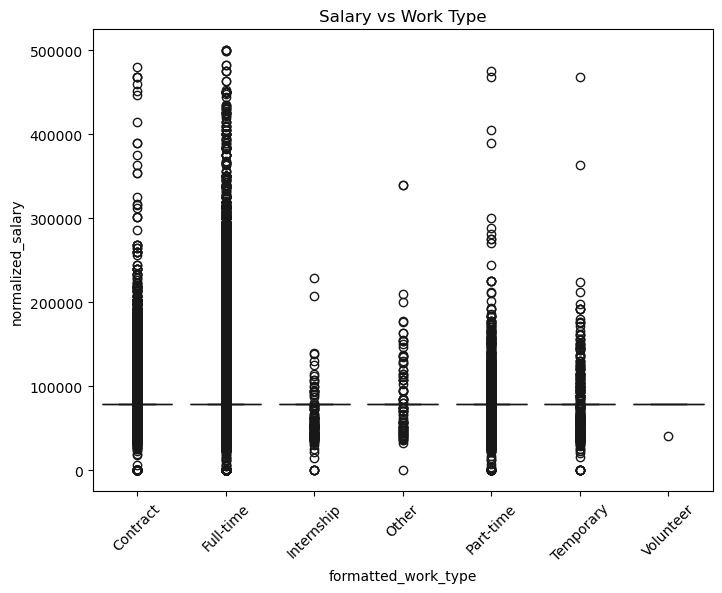

In [29]:
# Salary by Work Type

plt.figure(figsize=(8,6))
sns.boxplot(x="formatted_work_type", y="normalized_salary", data=df, palette="mako")
plt.title("Salary vs Work Type")
plt.xticks(rotation=45)

# Save the plot to a path
plt.savefig(r"C:/Users/poona/Desktop/MS_ADS/sem3/ML 2/SmartApply/results/Salary_by_workType.png", dpi=300) 
plt.show()


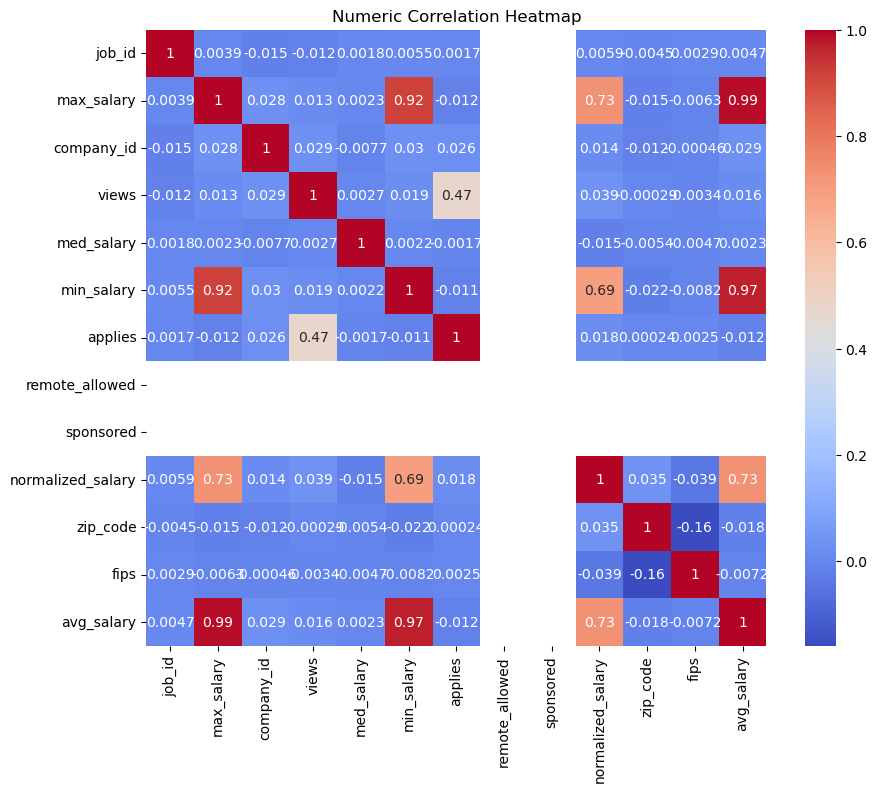

In [30]:
# Correlation Matrix 

numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Numeric Correlation Heatmap")

# Save the plot to a path
plt.savefig(r"C:/Users/poona/Desktop/MS_ADS/sem3/ML 2/SmartApply/results/correlation_heatmap.png", dpi=300) 
plt.show()


In [31]:
def prepare_features(df):
    feature_df = df[[
        "job_id", "company_name", "title", "description", "formatted_experience_level",
        "formatted_work_type", "location", "normalized_salary", "skills_desc"
    ]].copy()

    # Derived features
    feature_df["job_title_length"] = feature_df["title"].apply(lambda x: len(str(x)))
    feature_df["description_length"] = feature_df["description"].apply(lambda x: len(str(x)))
    feature_df["is_remote"] = feature_df["location"].str.contains("Remote", case=False, na=False).astype(int)
    
    return feature_df

df_features = prepare_features(df)


In [32]:
os.makedirs("data/processed", exist_ok=True)
df_features.to_csv("C:/Users/poona/Desktop/MS_ADS/sem3/ML 2/SmartApply/data/cleaned_jobs.csv", index=False)
print("Cleaned dataset saved to data/cleaned_jobs.csv")


Cleaned dataset saved to data/cleaned_jobs.csv
